## Score scraping

In [261]:
# package use
import requests
import urllib
import urllib.request
import time
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from IPython.core.display import HTML

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import copy
from collections import Counter

In [26]:
# read box office table first
boxOffice = pd.read_csv("boxofficemojo-top200-2004-2015_complete.csv", encoding='ISO-8859-1')
# read director films table then
directorFilm = pd.read_csv("imdb-director-films.csv", encoding='ISO-8859-1')

In [27]:
boxOffice.head(1)

,year,bomrank,remove,bomtitle,imdblink,bomlink,Unnamed: 6,studio,totalusgross$,totaltheater,openingusgross$,openingtheaters,opendate,closedate,critic ratings_avg,critic rating_var,user_avg,user_var,critic_ratings_comments
0,2004.0,1.0,NaN,Shrek 2,http://www.imdb.com/title/tt0298148/,http://www.boxofficemojo.com/movies/?id=shrek2...,NaN,DW,441226247.0,4223.0,108037878.0,4163.0,5/19,11/25,NaN,NaN,NaN,NaN,NaN


In [28]:
directorFilm.head(1)

,imdbcrewcastname,imdbcrewcastlink,year,imdbfilmtitle,role,imdbfilmlink
0,A.R. Murugadoss,http://www.imdb.com/name/nm1436693/,2017.0,Spyder,Director,http://www.imdb.com/title/tt6522546/


### Take the first film as example to check user rating columns

In [29]:
# fill ratings and comments 
# add ratings string to return rating url for films
url = boxOffice['imdblink'][0] + "ratings"
print(url)
response = requests.get(url)
# analyze rating website information
soup = BeautifulSoup(response.text, "html.parser")
# find number of ratings and average score
def find_avg_total(soup_):
    string = soup_.findAll('div', {'class': "allText"})[0].text.replace(",", "")
    return re.findall(r"\d+\.?\d*", string)

result_score = find_avg_total(soup)
print(result_score)

http://www.imdb.com/title/tt0298148/ratings
['378773', '7.2', '10']


In [30]:
text_html = soup.findAll('div', {'class': ["allText", "leftAligned", "topAligned", "rightAligned"]})
# extract all numbers in the chart and return list
def get_numList(text_html_):
    text_string = ""
    for i in range(1, len(text_html_)):
        text_string = text_string + text_html_[i].text
    text_string = text_string.replace(",", "").replace("\n", " ").replace("\xa0", "")
    text_string = re.sub(r'[A-z]', '', text_string).split()
    return text_string

result_list = get_numList(text_html)
print(result_list)
print(len(result_list))

['1010', '8.7%', '8.7%', '32971', '3297199', '10.1%', '10.1%', '38130', '3813088', '25.4%', '25.4%', '96027', '9602777', '32.4%', '32.4%', '122684', '12268466', '14.6%', '14.6%', '55448', '5544855', '4.9%', '4.9%', '18712', '1871244', '1.8%', '1.8%', '6909', '690933', '0.9%', '0.9%', '3249', '324922', '0.5%', '0.5%', '1803', '180311', '0.7%', '0.7%', '2840', '2840', '=', '7.3', '=', '7']
45


In [31]:
def variance_dic(text_string_):
    # set up blank dictionary first
    dic = {}
    # fill in next if all levels are included
    if len(text_string_) == 45:
        for i in range(10):
            sub_string = text_string_[4*i:(4*i+4)]
            dic[10-i] = [float(sub_string[1].strip("%"))/100, float(sub_string[3])]
    return dic
result_dic = variance_dic(result_list)
print(result_dic)

{10: [0.087, 32971.0], 9: [0.10099999999999999, 38130.0], 8: [0.254, 96027.0], 7: [0.324, 122684.0], 6: [0.146, 55448.0], 5: [0.049, 18712.0], 4: [0.018000000000000002, 6909.0], 3: [0.009000000000000001, 3249.0], 2: [0.005, 1803.0], 1: [0.006999999999999999, 2840.0]}


### Calculate variance based on distribution
* Formula: D(X)=sigma(pi*(xi-u)^2)

In [32]:
# calculate variance based on the dictionary
def variance_calculate(dic_):
    # full dictionary to calculate variance
    variance = np.nan
    if len(dic_) == 10:
        variance = 0
        for index in range(len(dic_)):
            mu = float(result_score[1])
            variance = variance + result_dic[10-index][0]*(10-index-mu)*(10-index-mu)
    return variance
variance_calculate(result_dic)    

2.3796

### Now fill in the user_avg and user_var column

In [ ]:
print(len(boxOffice))
for l in range(len(boxOffice)):
    # give the url address first
    if "http" in str(boxOffice['imdblink'][l]):
        url = boxOffice['imdblink'][l] + "ratings"
        response = requests.get(url)
        # analyze rating website information
        soup = BeautifulSoup(response.text, "html.parser")
        # find number of ratings and average score
        result_score = find_avg_total(soup)

        # return the second term as average
        boxOffice['user_avg'][l] = float(result_score[1])
        # calculate the variance
        text_html = soup.findAll('div', {'class': ["allText", "leftAligned", "topAligned", "rightAligned"]})
        # scores distribution list
        result_list = get_numList(text_html)
        # scores and their number of votes and percentage dictionary
        result_dic = variance_dic(result_list)
        score = variance_calculate(result_dic) 
        boxOffice['user_var'][l] = score
    # check process
    if l%200 == 0:
        print(l)

In [71]:
# deal with not full dictionary variance last
# find those items first
left_index = boxOffice[(boxOffice['user_avg'].notnull())& 
                       (boxOffice['user_var'].isnull())].index.values.astype(int).tolist()
print(left_index)

[1194, 1597, 1799, 1941]


In [70]:
def variance_dic_notFull(text_string_):
    # set up blank dictionary first
    dic = {}
    temp = copy.deepcopy(text_string_)
    # fill in next if all levels are included
    for i in range(10):
        sub_string = temp[4*i:(4*i+4)]
        if '0' in sub_string:
            dic[10-i] = [0, 0]
            temp = [0, 0] + temp
        else:
            dic[10-i] = [float(sub_string[1].strip("%"))/100, float(sub_string[3])]
    return dic

In [72]:
for index in left_index:
    url = boxOffice['imdblink'][index] + "ratings"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    result_score = find_avg_total(soup)
    text_html = soup.findAll('div', {'class': ["allText", "leftAligned", "topAligned", "rightAligned"]})
    result_list = get_numList(text_html)
    result_dic = variance_dic_notFull(result_list)
    score = variance_calculate(result_dic) 
    boxOffice['user_var'][index] = score

In [73]:
# write boxOffice and store
boxOffice.to_csv("boxOffice_userfilled.csv")

In [87]:
boxOffice = pd.read_csv("boxOffice_userfilled.csv")
Name_list = boxOffice.columns.tolist()
Name_list = [item for item in Name_list if 'Unnamed' not in item]
# kick out Unnamed columns for simplicity
boxOffice = boxOffice[Name_list]
boxOffice.head(5)

,year,bomrank,remove,bomtitle,imdblink,bomlink,studio,totalusgross$,totaltheater,openingusgross$,openingtheaters,opendate,closedate,critic ratings_avg,critic rating_var,user_avg,user_var,critic_ratings_comments
0,2004.0,1.0,NaN,Shrek 2,http://www.imdb.com/title/tt0298148/,http://www.boxofficemojo.com/movies/?id=shrek2...,DW,441226247.0,4223.0,108037878.0,4163.0,5/19,11/25,NaN,NaN,7.2,2.37960,NaN
1,2004.0,2.0,NaN,Spider-Man 2,http://www.imdb.com/title/tt0316654/,http://www.boxofficemojo.com/movies/?id=spider...,Sony,373585825.0,4166.0,88156227.0,4152.0,6/30,12/19,NaN,NaN,7.3,2.86249,NaN
2,2004.0,3.0,NaN,The Passion of the Christ,http://www.imdb.com/title/tt0335345/,http://www.boxofficemojo.com/movies/?id=passio...,NM,370274604.0,3408.0,83848082.0,3043.0,2/25,7/29,NaN,NaN,7.2,6.34920,NaN
3,2004.0,4.0,NaN,Meet the Fockers,http://www.imdb.com/title/tt0290002/,http://www.boxofficemojo.com/movies/?id=meetth...,Uni.,279261160.0,3554.0,46120980.0,3518.0,12/22,6/16,NaN,NaN,6.3,2.78720,NaN
4,2004.0,5.0,NaN,The Incredibles,http://www.imdb.com/title/tt0317705/,http://www.boxofficemojo.com/movies/?id=incred...,BV,261441092.0,3933.0,70467623.0,3933.0,11/5,4/14,NaN,NaN,8.0,2.39500,NaN


In [102]:
print('Num of blanks: ', len(boxOffice[(boxOffice['user_avg'].isnull())|(boxOffice['user_var'].isnull())]))

Num of blanks:  11


[[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018330CE6320>


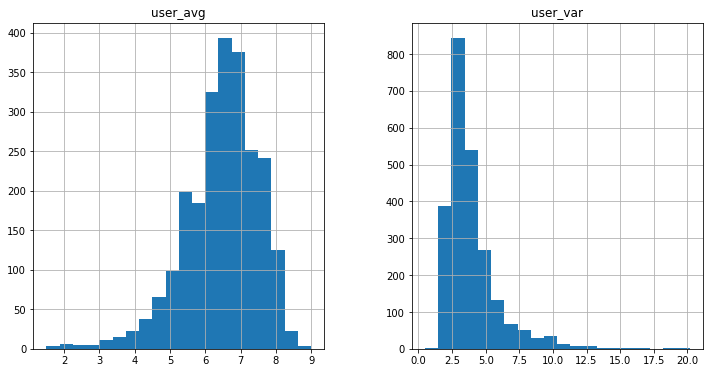

In [98]:
hist = boxOffice[['user_avg', 'user_var']].hist(bins=20, figsize=[12, 6])
print(hist)

### Take the first film as example to check critic ratings_avg and critic rating_var columns

In [196]:
url = boxOffice['imdblink'][0] + 'criticreviews'
print(url)
response = requests.get(url)
# analyze rating website information
soup = BeautifulSoup(response.text, "html.parser")

http://www.imdb.com/title/tt0298148/criticreviews


In [197]:
# find the criticl rating list 
# combine both the "critscore critscore_mixed" and "critscore critscore_favorable" 
# and "critscore critscore_unfavorable" scores
def critic_scoreList_extract(soup_):
    filter_list = soup_.findAll('div', {'class': ["critscore critscore_favorable", 
                                                  "critscore critscore_mixed", 
                                                  "critscore critscore_unfavorable"]})
    score_list = []
    for l in range(len(filter_list)):
        # extract the critical score information
        score = filter_list[l].text.replace('\n','')
        score_list.append(float(score))
    return score_list
result_score = critic_scorelist_extract(soup)
# will return blank list if there are no meta score available

# if the result_score is not blank
# turn the list into string for storing later as well
score_list_string = str(result_score[0])
for num in result_score[1:]:
    score_list_string = score_list_string + "||" + str(num)

print(result_score)
print(score_list_string)
print(score_list_string.split("||"))

[90.0, 88.0, 80.0, 80.0, 80.0, 75.0, 75.0, 70.0, 60.0, 60.0]
90.0||88.0||80.0||80.0||80.0||75.0||75.0||70.0||60.0||60.0
['90.0', '88.0', '80.0', '80.0', '80.0', '75.0', '75.0', '70.0', '60.0', '60.0']


In [198]:
# get meta final score if the result score list is not blank
def critic_scoreMean_extract(soup_):
    filter_score = soup.findAll('div', {'class': ["metascore score_favorable", 
                                                  "metascore score_unfavorable", 
                                                  "metascore score_mixed"]})
    # there will be only one available category for each film
    if len(filter_score) > 0:
        score = float(filter_score[0].text.replace("\n", ""))
    else:
        score = np.nan
    return score
critic_scoreMean_extract(soup)

75.0

In [199]:
# extract the comments and store as string corresponding to the score order 
# use "||" to separate different comments
def comment_extract(soup_):
    filter_comment = soup_.findAll('div', {'itemprop': "reviewbody"})
    # if the result score is not blank as well
    # then add the comments 
    comment = filter_comment[0].text.replace("\n", "")
    for l in range(1, len(filter_comment)):
        comment = comment + "||" + filter_comment[l].text.replace("\n", "")
    return comment

print(comment_extract(soup)[0:205])

 Lightning strikes twice, but not as brilliantly as before, in Shrek 2. The welcome sequel to the monster 2001 Oscar winner about an ogre's unlikely romance with a beautiful princess successfully recycles 


In [200]:
# calculate the variance based on the avg score and meta score list
def variance_calculate(avg_, list_):
    variance = 0
    for item in list_:
        variance = variance + (item-avg_)*(item-avg_)
    return variance/len(list_)
variance_calculate(critic_scoreMean_extract(soup), result_score)

94.4

### Now fill in the critic ratings_avg and critic rating_var columns/comments included

In [205]:
# add critic_ratings_list to record score list
boxOffice['critic_ratings_list'] = np.nan

In [ ]:
for l in range(len(boxOffice)):
    # make sure available url address to check
    if "http" in str(boxOffice['imdblink'][l]):
        url = boxOffice['imdblink'][l] + 'criticreviews'
        response = requests.get(url)
        soup = BeautifulSoup(response.text, "html.parser")
        
        # start to check meta score
        # will return blank list if there are no meta score available
        result_score = critic_scorelist_extract(soup)
        # available many scores
        if len(result_score) > 0:
            # get score list string first and fill in
            score_list_string = str(result_score[0])
            for num in result_score[1:]:
                score_list_string = score_list_string + "||" + str(num)
            boxOffice['critic_ratings_list'][l] = score_list_string
            # get critic average score and fill in
            avg_score = critic_scoreMean_extract(soup)
            boxOffice['critic ratings_avg'][l] = avg_score
            # calculate variance for meta score and fill in
            variance_score = variance_calculate(avg_score, result_score)
            boxOffice['critic rating_var'][l] = variance_score
            # get comment string and fill in
            comment_str = comment_extract(soup)
            boxOffice['critic_ratings_comments'][l] = comment_str
        # no available scores and comments
        else:
            boxOffice['critic_ratings_list'][l] = np.nan
            boxOffice['critic ratings_avg'][l] = np.nan
            boxOffice['critic rating_var'][l] = np.nan
            boxOffice['critic_ratings_comments'][l] = np.nan
    # check process
    if l%100 == 0:
        print(l)

In [207]:
# write boxOffice and store
boxOffice.to_csv("boxOffice_Allfilled.csv")

In [215]:
boxOffice_Allfilled = pd.read_csv("boxOffice_Allfilled.csv")
Name_list = boxOffice_Allfilled.columns.tolist()
Name_list = [item for item in Name_list if 'Unnamed' not in item]
# kick out Unnamed columns for simplicity
boxOffice_Allfilled = boxOffice_Allfilled[Name_list]
boxOffice_Allfilled.head(5)

,year,bomrank,remove,bomtitle,imdblink,bomlink,studio,totalusgross$,totaltheater,openingusgross$,openingtheaters,opendate,closedate,critic ratings_avg,critic rating_var,user_avg,user_var,critic_ratings_comments,critic_ratings_list
0,2004.0,1.0,NaN,Shrek 2,http://www.imdb.com/title/tt0298148/,http://www.boxofficemojo.com/movies/?id=shrek2...,DW,441226247.0,4223.0,108037878.0,4163.0,5/19,11/25,75.0,94.4,7.2,2.37960,"Lightning strikes twice, but not as brilliant...",90.0||88.0||80.0||80.0||80.0||75.0||75.0||70.0...
1,2004.0,2.0,NaN,Spider-Man 2,http://www.imdb.com/title/tt0316654/,http://www.boxofficemojo.com/movies/?id=spider...,Sony,373585825.0,4166.0,88156227.0,4152.0,6/30,12/19,83.0,115.2,7.3,2.86249,The pleasure is doubled in Spider-Man 2. Crac...,100.0||100.0||100.0||91.0||90.0||90.0||88.0||8...
2,2004.0,3.0,NaN,The Passion of the Christ,http://www.imdb.com/title/tt0335345/,http://www.boxofficemojo.com/movies/?id=passio...,NM,370274604.0,3408.0,83848082.0,3043.0,2/25,7/29,47.0,663.9,7.2,6.34920,"This is not a sermon or a homily, but a visua...",100.0||80.0||80.0||75.0||63.0||63.0||50.0||50....
3,2004.0,4.0,NaN,Meet the Fockers,http://www.imdb.com/title/tt0290002/,http://www.boxofficemojo.com/movies/?id=meetth...,Uni.,279261160.0,3554.0,46120980.0,3518.0,12/22,6/16,41.0,298.8,6.3,2.78720,One of those relatively rare comedies that's ...,70.0||63.0||60.0||60.0||50.0||50.0||50.0||40.0...
4,2004.0,5.0,NaN,The Incredibles,http://www.imdb.com/title/tt0317705/,http://www.boxofficemojo.com/movies/?id=incred...,BV,261441092.0,3933.0,70467623.0,3933.0,11/5,4/14,90.0,100.0,8.0,2.39500,Pixar again hitches top-notch storytelling to...,100.0||100.0||100.0||100.0||100.0||90.0||90.0|...


In [216]:
print('Num of blanks: ', len(boxOffice_Allfilled[boxOffice_Allfilled['critic ratings_avg'].isnull()]))

Num of blanks:  100


[[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018333DC2C18>


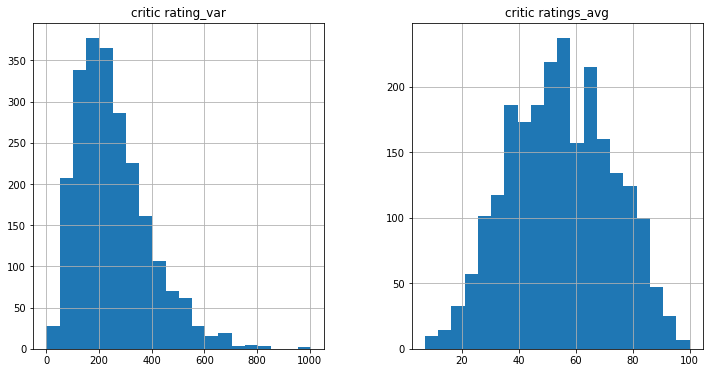

In [217]:
hist_Allfilled = boxOffice_Allfilled[['critic ratings_avg',
                                      'critic rating_var']].hist(bins=20, figsize=[12, 6])
print(hist_Allfilled)

Text(0.5, 1.0, "User ratings'average vs.variance distribution")

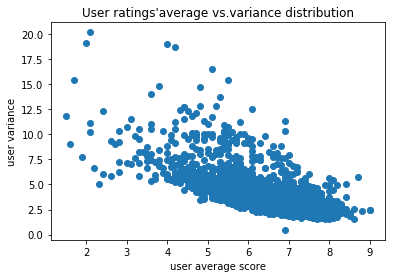

In [259]:
plot_Allfilled = boxOffice_Allfilled[(boxOffice_Allfilled['user_var'].notnull())&
                                     (boxOffice_Allfilled['user_avg'].notnull())].reset_index(drop=True)
user_avg = plot_Allfilled['user_avg'].values.tolist()
user_var = plot_Allfilled['user_var'].values.tolist()
critic_avg = plot_Allfilled['critic ratings_avg'].values.tolist()
critic_var =plot_Allfilled['critic rating_var'].values.tolist()
year =plot_Allfilled['year'].values.tolist()

# plot
plt.scatter(user_avg, user_var)
plt.xlabel("user average score")
plt.ylabel("user variance")
plt.title("User ratings'average vs.variance distribution")

Text(0.5, 1.0, "Critic ratings'average vs.variance distribution")

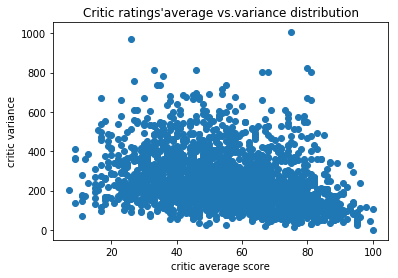

In [258]:
# plot
plt.scatter(critic_avg, critic_var)
plt.xlabel("critic average score")
plt.ylabel("critic variance")
plt.title("Critic ratings'average vs.variance distribution")

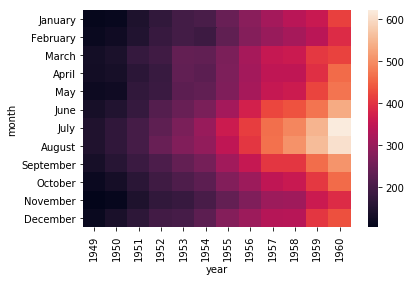

In [262]:
# one example for further visualization
# heatmap plot samples
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
ax = sns.heatmap(flights)